In [0]:
import time
import math
import os
import os.path
import numpy as np
import pandas as pd
import io

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection  import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

os.getcwd()

In [0]:
# read in data
df_immunization = pd.read_csv('NISPUF17.csv')
df_immunization.head()

#df_immunization.PU431331.value_counts()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,375,384,393,394,402,403,408,409,420,421,429,444) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEQNUMC,SEQNUMHH,PDAT,PROVWT_D,RDDWT_D,STRATUM,YEAR,AGECPOXR,HAD_CPOX,AGEGRP,BF_ENDR06,BF_EXCLR06,BF_FORMR08,BFENDFL06,BFFORMFL06,C1R,C5R,CBF_01,CEN_REG,CHILDNM,CWIC_01,CWIC_02,EDUC1,FRSTBRN,I_HISP_K,INCPORAR,INCPORAR_I,INCPOV1,INCQ298A,LANGUAGE,M_AGEGRP2,MARITAL2,MOBIL_I,NUM_PHONE,NUM_CELLS_HH,NUM_CELLS_PARENTS,RACE_K,RACEETHK,RENT_OWN,SEX,...,XMMRTY8,XMMRTY9,XPCVTY1,XPCVTY2,XPCVTY3,XPCVTY4,XPCVTY5,XPCVTY6,XPCVTY7,XPCVTY8,XPCVTY9,XPOLTY1,XPOLTY2,XPOLTY3,XPOLTY4,XPOLTY5,XPOLTY6,XPOLTY7,XPOLTY8,XPOLTY9,XROTTY1,XROTTY2,XROTTY3,XROTTY4,XROTTY5,XROTTY6,XROTTY7,XROTTY8,XROTTY9,XVRCTY1,XVRCTY2,XVRCTY3,XVRCTY4,XVRCTY5,XVRCTY6,XVRCTY7,XVRCTY8,XVRCTY9,INS_STAT2_I,INS_BREAK_I
0,NaN,NaN,CHILD DOES NOT HAVE ADEQUATE PROVIDER DATA,NaN,235.916956,1031,2017,NaN,NO,19 - 23 MONTHS,395.6875,121.75,NaN,NaN,NaN,8+,"MOTHER (STEP, FOSTER, ADOPTIVE) OR FEMALE GUAR...",YES,SOUTH,FOUR OR MORE,YES,YES,COLLEGE GRAD,NO,NON-HISPANIC,1.807991,1.807991,"ABOVE POVERTY, > $75K",$75001+,ENGLISH,>= 30 YEARS,NEVER MARRIED/WIDOWED/DIVORCED/SEPARATED/DECEA...,DID NOT MOVE FROM DIFFERENT STATE,ONE,THREE OR MORE,ONE,WHITE ONLY,NON-HISPANIC WHITE ONLY,OWNED OR BEING BOUGHT,MALE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,CHILD DOES NOT HAVE ADEQUATE PROVIDER DATA,NaN,957.353840,1068,2017,NaN,NO,19 - 23 MONTHS,NaN,NaN,NaN,NaN,NaN,6,"MOTHER (STEP, FOSTER, ADOPTIVE) OR FEMALE GUAR...",NO,WEST,FOUR OR MORE,YES,NO,"> 12 YEARS, NON-COLLEGE GRAD",NO,NON-HISPANIC,2.338634,2.338634,"ABOVE POVERTY, <= $75K",$60001 - $75000,ENGLISH,>= 30 YEARS,MARRIED,DID NOT MOVE FROM DIFFERENT STATE,ONE,THREE OR MORE,THREE OR MORE,BLACK ONLY,NON-HISPANIC BLACK ONLY,OWNED OR BEING BOUGHT,MALE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,CHILD DOES NOT HAVE ADEQUATE PROVIDER DATA,NaN,189.611299,1050,2017,NaN,NO,30 - 35 MONTHS,NaN,NaN,NaN,NaN,NaN,6,OTHER FAMILY MEMBER/FRIEND,NO,SOUTH,FOUR OR MORE,YES,NO,"> 12 YEARS, NON-COLLEGE GRAD",NO,NON-HISPANIC,2.494543,2.494543,"ABOVE POVERTY, > $75K",$75001+,ENGLISH,<= 29 YEARS,NEVER MARRIED/WIDOWED/DIVORCED/SEPARATED/DECEA...,DID NOT MOVE FROM DIFFERENT STATE,ONE,THREE OR MORE,TWO,WHITE ONLY,NON-HISPANIC WHITE ONLY,OWNED OR BEING BOUGHT,FEMALE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,CHILD HAS ADEQUATE PROVIDER DATA OR ZERO VACCI...,675.430817,333.447418,1040,2017,NaN,NO,19 - 23 MONTHS,NaN,NaN,NaN,NaN,NaN,3,"FATHER (STEP, FOSTER, ADOPTIVE) OR MALE GUARDIAN",NO,MIDWEST,ONE,NO,NaN,COLLEGE GRAD,YES,NON-HISPANIC,3.000000,3.000000,"ABOVE POVERTY, > $75K",$75001+,ENGLISH,>= 30 YEARS,MARRIED,DID NOT MOVE FROM DIFFERENT STATE,ONE,TWO,TWO,WHITE ONLY,NON-HISPANIC WHITE ONLY,OWNED OR BEING BOUGHT,FEMALE,...,NaN,NaN,PCV CONJUGATE-13,PCV CONJUGATE-13,PCV CONJUGATE-13,PCV CONJUGATE-13,NaN,NaN,NaN,NaN,NaN,DTAP-HEPB-IPV,DTAP-HEPB-IPV,DTAP-HEPB-IPV,NaN,NaN,NaN,NaN,NaN,NaN,ROTATEQ (MERCK),ROTATEQ (MERCK),ROTATEQ (MERCK),NaN,NaN,NaN,NaN,NaN,NaN,VARICELLA-ONLY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PRIVATE INSURANCE ONLY,CURRENTLY INSURED AND NEVER UNINSURED SINCE BIRTH
4,NaN,NaN,CHILD HAS ADEQUATE PROVIDER DATA OR ZERO VACCI...,482.617748,278.768063,1008,2017,NaN,NO,19 - 23 MONTHS,547.8750,273.90,NEVER FED FORMULA,NaN,NaN,7,"MOTHER (STEP, FOSTER, ADOPTIVE) OR FEMALE GUAR...",YES,NORTHEAST,TWO OR THREE,YES,YES,< 12 YEARS,NO,HISPANIC,0.500000,0.500000,BELOW POVERTY,$0 - $7500,SPANISH,>= 30 YEARS,NEVER MARRIED/WIDOWED/DIVORCED/SEPARATED/DECEA...,DID NOT MOVE FROM DIFFERENT STATE,TWO,TWO,ONE,WHITE ONLY,HISPANIC,RENTED,FEMALE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANY MEDICAID,CURRENT

In [0]:
#only include people with PDAT == 1
df_immunization = df_immunization[df_immunization.PDAT == 'CHILD HAS ADEQUATE PROVIDER DATA OR ZERO VACCINATIONS']

#drop people of unknown poverty status
df_immunization = df_immunization[df_immunization.INCPOV1 != 'UNKNOWN']

#rename to form the IMMUNE column
df_immunization.rename(columns={'PU431331':'IMMUNE'}, inplace=True)

#recode IMMUNE as 0 or 1 (Up to date)
df_immunization['IMMUNE'] = df_immunization['IMMUNE'].map({'UTD': 1, 'NOT UTD': 0})

#recode census region
df_immunization['CEN_REG'] = df_immunization['CEN_REG'].map({'WEST': 1, 'MIDWEST': 2, 'NORTHEAST': 3, 'SOUTH': 4})

#create dummy variables of categorical features
df_immunization = pd.get_dummies(df_immunization, columns=['FRSTBRN','CEN_REG', 'EDUC1', 'INCPOV1', 'M_AGEGRP2', 'RACEETHK', 'INS_STAT2_I','CHILDNM','CWIC_01'], prefix = ['FRSTBRN','CEN_REG', 'EDUC1', 'INCPOV1', 'M_AGEGRP2', 'RACEETHK', 'INS_STAT2_I','CHILDNM','CWIC_01'])

#name the pred_columns group
pred_columns = ['FRSTBRN_1',	'FRSTBRN_2','CEN_REG_1'	, 'CEN_REG_2'	,'CEN_REG_3',	'CEN_REG_4', 'EDUC1_1',	'EDUC1_2',	'EDUC1_3',	'EDUC1_4', 'INCPOV1_1',	'INCPOV1_2',	'INCPOV1_3', 'M_AGEGRP2_1',	'M_AGEGRP2_2'	, 'RACEETHK_1',	'RACEETHK_2',	'RACEETHK_3',	'RACEETHK_4', 'INS_STAT2_I_1',	'INS_STAT2_I_2',	'INS_STAT2_I_3',	'INS_STAT2_I_4','BF_ENDR06', 'CHILDNM_1',	'CHILDNM_2', 	'CHILDNM_3'	,'CWIC_01_1',	'CWIC_01_2', 'IMMUNE']

#shrink df to only include predictors and target
relevant_columns = ['FRSTBRN_1',	'FRSTBRN_2','CEN_REG_1'	, 'CEN_REG_2'	,'CEN_REG_3',	'CEN_REG_4', 'EDUC1_1',	'EDUC1_2',	'EDUC1_3',	'EDUC1_4', 'INCPOV1_1',	'INCPOV1_2',	'INCPOV1_3', 'M_AGEGRP2_1',	'M_AGEGRP2_2'	, 'RACEETHK_1',	'RACEETHK_2',	'RACEETHK_3',	'RACEETHK_4', 'INS_STAT2_I_1',	'INS_STAT2_I_2',	'INS_STAT2_I_3',	'INS_STAT2_I_4','BF_ENDR06', 'CHILDNM_1',	'CHILDNM_2', 	'CHILDNM_3'	,'CWIC_01_1',	'CWIC_01_2', 'IMMUNE']

#drop NA rows
df_immunization = df_immunization[relevant_columns]
df_immunization = df_immunization.dropna()

#name columns to scale
scaled_columns = ['BF_ENDR06']

df_immunization.describe
df_immunization

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,375,384,393,394,402,403,408,409,420,421,429,444) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEQNUMC,SEQNUMHH,PDAT,PROVWT_D,RDDWT_D,STRATUM,YEAR,AGECPOXR,HAD_CPOX,AGEGRP,BF_ENDR06,BF_EXCLR06,BF_FORMR08,BFENDFL06,BFFORMFL06,C1R,C5R,CBF_01,CWIC_02,I_HISP_K,INCPORAR,INCPORAR_I,INCQ298A,LANGUAGE,MARITAL2,MOBIL_I,NUM_PHONE,NUM_CELLS_HH,NUM_CELLS_PARENTS,RACE_K,RENT_OWN,SEX,ESTIAP17,EST_GRANT,STATE,D6R,D7,N_PRVR,PROV_FAC,REGISTRY,...,XVRCTY2,XVRCTY3,XVRCTY4,XVRCTY5,XVRCTY6,XVRCTY7,XVRCTY8,XVRCTY9,INS_BREAK_I,FRSTBRN_NO,FRSTBRN_YES,CEN_REG_1,CEN_REG_2,CEN_REG_3,CEN_REG_4,EDUC1_12 YEARS,EDUC1_< 12 YEARS,"EDUC1_> 12 YEARS, NON-COLLEGE GRAD",EDUC1_COLLEGE GRAD,"INCPOV1_ABOVE POVERTY, <= $75K","INCPOV1_ABOVE POVERTY, > $75K",INCPOV1_BELOW POVERTY,M_AGEGRP2_<= 29 YEARS,M_AGEGRP2_>= 30 YEARS,RACEETHK_HISPANIC,RACEETHK_NON-HISPANIC BLACK ONLY,RACEETHK_NON-HISPANIC OTHER + MULTIPLE RACE,RACEETHK_NON-HISPANIC WHITE ONLY,INS_STAT2_I_ANY MEDICAID,INS_STAT2_I_OTHER INSURANCE,INS_STAT2_I_PRIVATE INSURANCE ONLY,INS_STAT2_I_UNINSURED,CHILDNM_FOUR OR MORE,CHILDNM_ONE,CHILDNM_TWO OR THREE,CWIC_01_DON'T KNOW,CWIC_01_NEVER HEARD OF WIC,CWIC_01_NO,CWIC_01_REFUSED,CWIC_01_YES
3,NaN,NaN,CHILD HAS ADEQUATE PROVIDER DATA OR ZERO VACCI...,675.430817,333.447418,1040,2017,NaN,NO,19 - 23 MONTHS,NaN,NaN,NaN,NaN,NaN,3,"FATHER (STEP, FOSTER, ADOPTIVE) OR MALE GUARDIAN",NO,NaN,NON-HISPANIC,3.000000,3.000000,$75001+,ENGLISH,MARRIED,DID NOT MOVE FROM DIFFERENT STATE,ONE,TWO,TWO,WHITE ONLY,OWNED OR BEING BOUGHT,FEMALE,MN,MN,MINNESOTA,1,YES,1,ALL PRIVATE FACILITIES,ALL PROVIDERS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CURRENTLY INSURED AND NEVER UNINSURED SINCE BIRTH,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0
4,NaN,NaN,CHILD HAS ADEQUATE PROVIDER DATA OR ZERO VACCI...,482.617748,278.768063,1008,2017,NaN,NO,19 - 23 MONTHS,547.8750,273.9000,NEVER FED FORMULA,NaN,NaN,7,"MOTHER (STEP, FOSTER, ADOPTIVE) OR FEMALE GUAR...",YES,YES,HISPANIC,0.500000,0.500000,$0 - $7500,SPANISH,NEVER MARRIED/WIDOWED/DIVORCED/SEPARATED/DECEA...,DID NOT MOVE FROM DIFFERENT STATE,TWO,TWO,ONE,WHITE ONLY,RENTED,FEMALE,NJ,NJ,NEW JERSEY,1,YES,1,ALL HOSPITAL FACILITIES,NO PROVIDERS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CURRENTLY INSURED BUT UNINSURED AT SOME POINT ...,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
6,NaN,NaN,CHILD HAS ADEQUATE PROVIDER DATA OR ZERO VACCI...,516.427723,248.916038,1008,2017,NaN,NO,30 - 35 MONTHS,121.7500,121.7500,NaN,NaN,NaN,3,"MOTHER (STEP, FOSTER, ADOPTIVE) OR FEMALE GUAR...",YES,YES,HISPANIC,2.068573,2.068573,$35001 - $40000,ENGLISH,NEVER MARRIED/WIDOWED/DIVORCED/SEPARATED/DECEA...,DID NOT MOVE FROM DIFFERENT STATE,ONE,ONE,ONE,BLACK ONLY,RENTED,FEMALE,NJ,NJ,NEW JERSEY,1,YES,1,ALL PRIVATE FACILITIES,ALL PROVIDERS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CURRENTLY INSURED AND NEVER UNINSURED SINCE BIRTH,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
7,NaN,NaN,CHILD HAS ADEQUATE PROVIDER DATA OR ZERO VACCI...,313.225832,163.213401,1001,2017,NaN,NO,24 - 29 MONTHS,365.2500,152.1875,NEVER FED FORMULA,NaN,NaN,5,"MOTHER (STEP, FOSTER, ADOPTIVE) OR FEMALE GUAR...",YES,NaN,NON-HISPANIC,3.000000,3.000000,$75001+,ENGLISH,MARRIED,MOVED FROM DIFFERENT STATE,ONE,TWO,TWO,WHITE ONLY,OWNED OR BEING BOUGHT,FEMALE,CT,CT,CONNECTICUT,2,YES,2,MIXED,SOME BUT POSSIBLY OR DEFINITELY NOT ALL PROVIDERS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CURRENTLY INSURED AND NEVER UNINSURED SINCE BIRTH,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0
8,NaN,NaN,CHILD HAS ADEQUATE PROVIDER DATA OR ZERO VACCI...,978.042448,718.616990,1016,2017,13 TO 18 MONTHS OLD,YES,19 - 23 MONTHS,456.5625,91.3125,NEVER FED FORMULA,NaN,NaN,7,"MOTHER (STEP, FOSTER, ADOPTIVE) OR FEMALE GUAR...",YES,NaN,NON-HISPANIC,1.475501,1.475501,$50001 - $60000,ENGLISH,MARRIED,DID NOT MOVE FROM DIFFERENT STATE,ONE,TWO,TWO,WHITE ONLY,OWNED OR BEING BOUGHT,MALE,PA-REST OF STATE,PA-REST OF STATE,PENNSYLVANIA,1,YES,1,ALL HOSPITAL FACILITIES,ALL PROVIDERS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CURRENTLY UNINSURED AND NEVER INSURED SINCE BIRTH,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,

In [0]:
df_immunization.isnull().sum()

CEN_REG        0
EDUC1          0
FRSTBRN        0
INCPOV1        0
M_AGEGRP2      0
RACEETHK       0
INS_STAT2_I    0
BF_ENDR06      0
CBF_01         0
CHILDNM        0
CWIC_01        0
IMMUNE         0
dtype: int64

In [0]:
df_immunization.head()

,CEN_REG,EDUC1,FRSTBRN,INCPOV1,M_AGEGRP2,RACEETHK,INS_STAT2_I,BF_ENDR06,CBF_01,CHILDNM,CWIC_01,IMMUNE
4,NORTHEAST,< 12 YEARS,NO,BELOW POVERTY,>= 30 YEARS,HISPANIC,ANY MEDICAID,547.8750,YES,TWO OR THREE,YES,0
6,NORTHEAST,COLLEGE GRAD,NO,"ABOVE POVERTY, <= $75K",>= 30 YEARS,HISPANIC,PRIVATE INSURANCE ONLY,121.7500,YES,TWO OR THREE,YES,1
7,NORTHEAST,"> 12 YEARS, NON-COLLEGE GRAD",NO,"ABOVE POVERTY, > $75K",<= 29 YEARS,NON-HISPANIC WHITE ONLY,OTHER INSURANCE,365.2500,YES,TWO OR THREE,NO,0
8,NORTHEAST,12 YEARS,NO,"ABOVE POVERTY, <= $75K",>= 30 YEARS,NON-HISPANIC WHITE ONLY,UNINSURED,456.5625,YES,FOUR OR MORE,NO,0
10,MIDWEST,"> 12 YEARS, NON-COLLEGE GRAD",NO,"ABOVE POVERTY, <= $75K",>= 30 YEARS,NON-HISPANIC WHITE ONLY,PRIVATE INSURANCE ONLY,304.3750,YES,TWO OR THREE,NO,1


In [0]:
print(df_immunization.describe())
scaler = MinMaxScaler()

scaler.fit(df_immunization[scaled_columns]) #Transform indexes to min max scaling
df_immunization[scaled_columns]=scaler.transform(df_immunization[scaled_columns])


          BF_ENDR06        IMMUNE
count  11830.000000  11830.000000
mean     293.563985      0.809552
std      195.281424      0.392671
min        1.000000      0.000000
25%      121.750000      1.000000
50%      273.937500      1.000000
75%      395.687500      1.000000
max      730.500000      1.000000


In [0]:
# Create a y dataset with just label variable
df_y=df_immunization['IMMUNE']
df_x=df_immunization[pred_columns]

In [0]:
df_x.shape

(11830, 10)

In [0]:
### Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)


In [0]:
def rfr_model(X, y):# Perform Grid-Search
    scores=['roc_auc']
    param_grid ={
    'max_depth': list(range(2,10)),
    'n_estimators': (50, 100, 500, 1000, 3000)
    }
    for score in scores:
        clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring=score)
        grid_result=clf.fit(X, y)
        best_params = grid_result.best_params_
        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()
    return grid_result
   

In [0]:
def gbc_model(X, y):# Perform Grid-Search on gradient boosted model 
    scores=['roc_auc']
    param_grid ={
    'learning_rate': (.01, .05 ,.1 ,.2, .3, .7),
    'max_depth': list(range(2,10))
    }
    for score in scores:
        clf = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, cv=5, scoring=score)
        grid_result=clf.fit(X, y)
        best_params = grid_result.best_params_
        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()
    return grid_result

In [0]:
def sv_model(X, y): #SupportVectorClassifier
    gammas =  [.0001, 0.001, 0.01, 0.1, 1, 10, 100, ]
    Cs=[.001, .01, .1, 1, 10]
    param_grid={
            'gamma': gammas,
            'C':Cs}
    scores=['roc_auc']
    for score in scores:
        clf = GridSearchCV(SVC(probability=True ), param_grid, cv=5, scoring=score)
        grid_result=clf.fit(X, y)
        best_params = grid_result.best_params_
        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()
    return grid_result
    

In [0]:
def nn_model(X, y): #neuralnetwork
    alphas =  [0.00001, 0.0001, 0.001, 0.01, 0.1, ]
    solvers = ['lbfgs', 'sgd', 'adam']
    activations=['identity', 'logistic', 'tanh', 'relu']
    param_grid={
            'alpha': alphas,
            'solver': solvers,
            'activation':activations}
    scores=['roc_auc']
    for score in scores:
        clf = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5, scoring=score)
        grid_result=clf.fit(X, y)
        best_params = grid_result.best_params_
        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()
    return grid_result    

In [0]:
#check for correlation
df_x.corr()


#first logit model
logit_model_1 = sm.Logit(df_y,df_x)
result = logit_model_1.fit()
print(result.summary2())

#second logit model, removing insignificant features
y_2 = df_immunization[['IMMUNE']]
X_2 = df_immunization[['CEN_REG', 'EDUC1', 'FRSTBRN', 'INCPOV1', 'M_AGEGRP2',
                #     'INS_STAT2_I', 'BF_ENDR06']]
logit_model_2 = sm.Logit(y_2,X_2)
result = logit_model_2.fit()
print(result.summary2())

,CEN_REG,EDUC1,FRSTBRN,INCPOV1,M_AGEGRP2,RACEETHK,INS_STAT2_I,BF_ENDR06,CHILDNM,CWIC_01
4,NORTHEAST,< 12 YEARS,NO,BELOW POVERTY,>= 30 YEARS,HISPANIC,ANY MEDICAID,0.749657,TWO OR THREE,YES
6,NORTHEAST,COLLEGE GRAD,NO,"ABOVE POVERTY, <= $75K",>= 30 YEARS,HISPANIC,PRIVATE INSURANCE ONLY,0.165524,TWO OR THREE,YES
7,NORTHEAST,"> 12 YEARS, NON-COLLEGE GRAD",NO,"ABOVE POVERTY, > $75K",<= 29 YEARS,NON-HISPANIC WHITE ONLY,OTHER INSURANCE,0.499315,TWO OR THREE,NO
8,NORTHEAST,12 YEARS,NO,"ABOVE POVERTY, <= $75K",>= 30 YEARS,NON-HISPANIC WHITE ONLY,UNINSURED,0.624486,FOUR OR MORE,NO
10,MIDWEST,"> 12 YEARS, NON-COLLEGE GRAD",NO,"ABOVE POVERTY, <= $75K",>= 30 YEARS,NON-HISPANIC WHITE ONLY,PRIVATE INSURANCE ONLY,0.415867,TWO OR THREE,NO
...,...,...,...,...,...,...,...,...,...,...
28438,SOUTH,12 YEARS,NO,"ABOVE POVERTY, <= $75K",<= 29 YEARS,HISPANIC,OTHER INSURANCE,0.958276,TWO OR THREE,YES
28440,SOUTH,COLLEGE GRAD,NO,"ABOVE POVERTY, <= $75K",<= 29 YEARS,NON-HISPANIC WHITE ONLY,ANY MEDICAID,0.374143,TWO OR THREE,YES
28446,SOUTH,"> 12 YEARS, NON-COLLEGE GRAD",YES,BELOW POVERTY,<= 29 YEARS,NON-HISPANIC WHITE ONLY,ANY MEDICAID,0.457591,ONE,YES
28449,MIDWEST,COLLEGE GRAD,YES,"ABOVE POVERTY, > $75K",>= 30 YEARS,NON-HISPANIC WHITE ONLY,PRIVATE INSURANCE ONLY,0.165524,ONE,NO


In [0]:
#COMMENT IN to TRAIN
rfr_grid=rfr_model(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: ignored

In [0]:
gbc_grid=gbc_model(X_train, y_train)

Best parameters set found on development set:

{'learning_rate': 0.01, 'max_depth': 2}

Grid scores on development set:

1.000 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 2}
1.000 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 3}
1.000 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 4}
1.000 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 5}
1.000 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 6}
1.000 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 7}
1.000 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 8}
1.000 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 9}
1.000 (+/-0.000) for {'learning_rate': 0.05, 'max_depth': 2}
1.000 (+/-0.000) for {'learning_rate': 0.05, 'max_depth': 3}
1.000 (+/-0.000) for {'learning_rate': 0.05, 'max_depth': 4}
1.000 (+/-0.000) for {'learning_rate': 0.05, 'max_depth': 5}
1.000 (+/-0.000) for {'learning_rate': 0.05, 'max_depth': 6}
1.000 (+/-0.000) for {'learning_rate': 0.05, 'max_depth': 7}
1.000 (+/-0.000) for {'le

In [0]:
sv_grid=sv_model(X_train, y_train)

Best parameters set found on development set:

{'C': 0.01, 'gamma': 0.0001}

Grid scores on development set:

0.620 (+/-0.031) for {'C': 0.001, 'gamma': 0.0001}
0.619 (+/-0.029) for {'C': 0.001, 'gamma': 0.001}
0.620 (+/-0.033) for {'C': 0.001, 'gamma': 0.01}
0.520 (+/-0.068) for {'C': 0.001, 'gamma': 0.1}
0.499 (+/-0.030) for {'C': 0.001, 'gamma': 1}
0.541 (+/-0.034) for {'C': 0.001, 'gamma': 10}
0.565 (+/-0.028) for {'C': 0.001, 'gamma': 100}
0.620 (+/-0.030) for {'C': 0.01, 'gamma': 0.0001}
0.619 (+/-0.026) for {'C': 0.01, 'gamma': 0.001}
0.532 (+/-0.065) for {'C': 0.01, 'gamma': 0.01}
0.512 (+/-0.071) for {'C': 0.01, 'gamma': 0.1}
0.525 (+/-0.042) for {'C': 0.01, 'gamma': 1}
0.570 (+/-0.012) for {'C': 0.01, 'gamma': 10}
0.590 (+/-0.020) for {'C': 0.01, 'gamma': 100}
0.620 (+/-0.030) for {'C': 0.1, 'gamma': 0.0001}
0.598 (+/-0.065) for {'C': 0.1, 'gamma': 0.001}
0.512 (+/-0.083) for {'C': 0.1, 'gamma': 0.01}
0.508 (+/-0.049) for {'C': 0.1, 'gamma': 0.1}
0.526 (+/-0.028) for {'C': 0.

In [0]:
nn_grid=nn_model(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: ignored

In [0]:
#COMMENT IN if training

#gbc parameters
best_max_depth_gbc=gbc_grid.best_params_["max_depth"] #
best_learning_rate=gbc_grid.best_params_["learning_rate"] #

#svc parameters
best_gamma=sv_grid.best_params_["gamma"] #
best_c_sv=sv_grid.best_params_["C"] #

#random forest parameters
best_max_depth_rf=rfr_grid.best_params_['max_depth']
best_n_estimators_rf=rfr_grid.best_params_['n_estimators']

#ffnn parameters
best_activation=nn_grid.best_params_['activation'] #
best_alpha=nn_grid.best_params_['alpha'] #
best_solver=nn_grid.best_params_['solver'] #

In [0]:
print(best_max_depth_gbc)
print(best_learning_rate)
print("---")
print(best_gamma)
print(best_c_sv)
print("---")
print(best_max_depth_rf)
print(best_n_estimators_rf)
print("---")
print(best_activation)
print(best_alpha)
print(best_solver)

2
0.01
---
---
2
50
---


In [0]:
# COMMENT OUT IF TRAINING
best_max_depth_gbc=2
best_learning_rate=.01

best_gamma= 0.0001
best_c_sv= 0.01

best_max_depth_rf=2
best_n_estimators_rf=50

best_activation='relu'
best_alpha=0.1
best_solver='adam'

In [0]:
RF_clf =RandomForestClassifier(max_depth=best_max_depth_rf, n_estimators=best_n_estimators_rf, 
                               random_state=42, warm_start=True, oob_score=True)
SV_clf =  SVC(gamma=best_gamma, C=best_c_sv, random_state=42, probability=True)
GBC_clf =  xgb.XGBClassifier(learning_rate=best_learning_rate, random_state=42, max_depth=best_max_depth_gbc)
LR_clf=LogisticRegression(random_state=42)
NN_clf = MLPClassifier(activation=best_activation, alpha=best_alpha, solver=best_solver, random_state=42)



X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.3, random_state=42)
logreg = LogisticRegression(solver='lbfgs', multi_class='auto')
logreg.fit(X_train, y_train.values.ravel())

In [0]:
RF_clf.fit(X_train, y_train.values.ravel())
print("Random Forest model score: %.3f" % RF_clf.score(X_test, y_test.values.ravel()))

SV_clf.fit(X_train, y_train.values.ravel())
print("SVC model score: %.3f" % SV_clf.score(X_test, y_test.values.ravel()))

GBC_clf.fit(X_train, y_train.values.ravel())
print("Gradient Boosting Classifier model score: %.3f" % GBC_clf.score(X_test, y_test.values.ravel()))

NN_clf.fit(X_train, y_train.values.ravel())
print("Neural Network Classifier model score: %.3f" % NN_clf.score(X_test, y_test.values.ravel()))

y_pred = logreg.predict(X_test)
print('Logistic regression model score: %.3f' %
logreg.score(X_test, y_test))

Random Forest model score: 0.818
Gradient Boosting Classifier model score: 1.000


AUC: 1.000


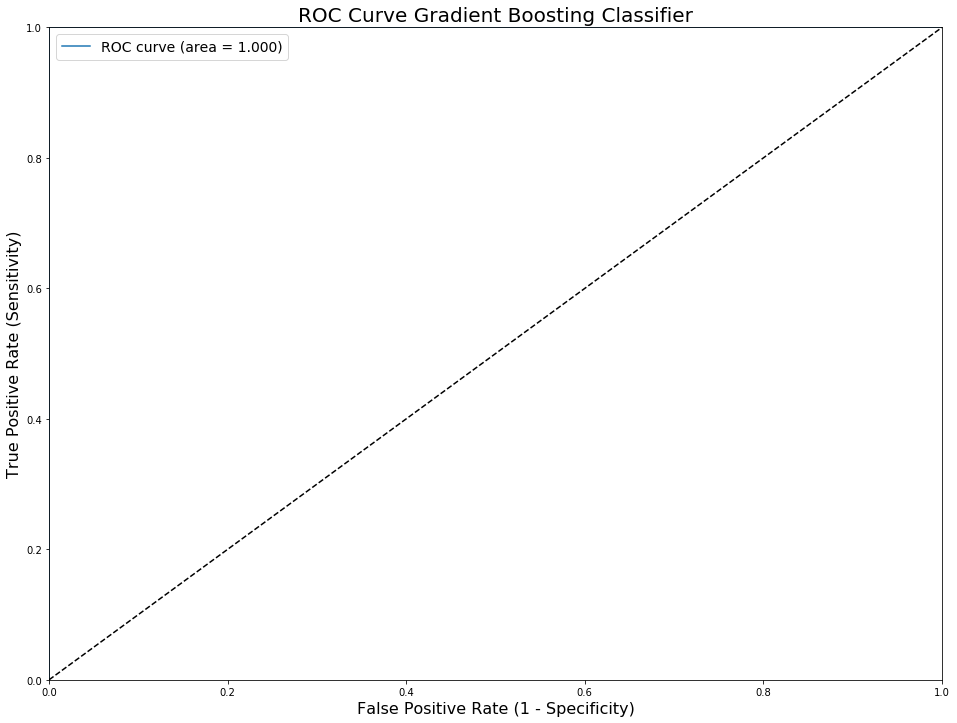

In [0]:
y_score=GBC_clf.predict_proba(X_test)
y_score=y_score[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)
print('AUC: %.3f' % roc_auc)

# Plot ROC curve
plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve Gradient Boosting Classifier', size=20)
plt.savefig('GBC_ROC')
plt.legend(fontsize=14);

AUC: 1.000


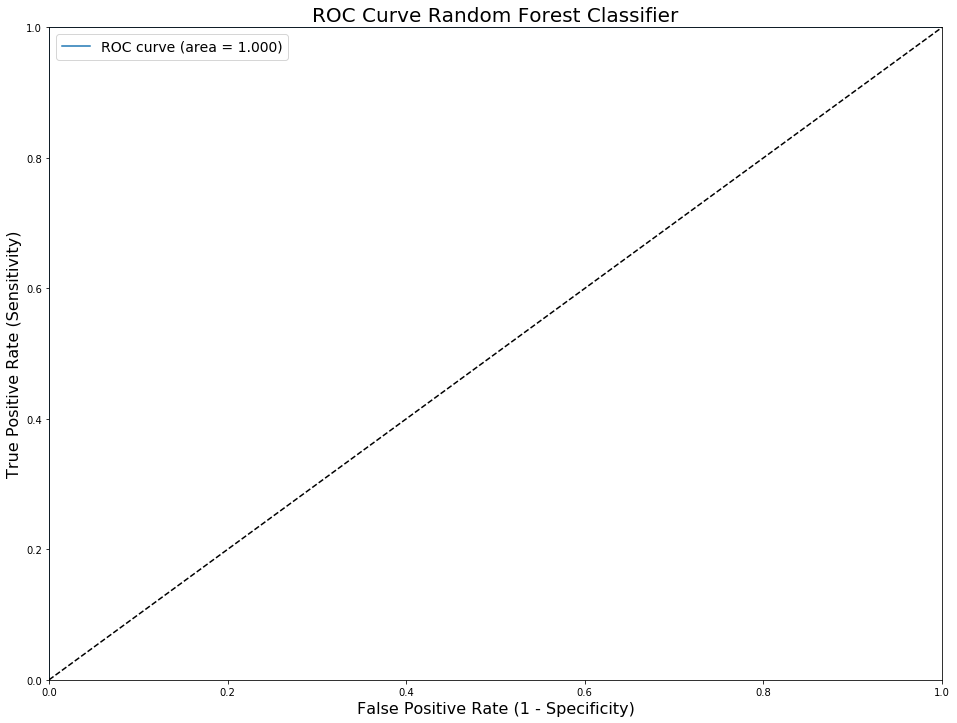

In [0]:
y_score=RF_clf.predict_proba(X_test)
y_score=y_score[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)
print('AUC: %.3f' % roc_auc)

# Plot ROC curve
plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve Random Forest Classifier', size=20)
plt.savefig('RF_ROC')
plt.legend(fontsize=14);

AUC: 0.592


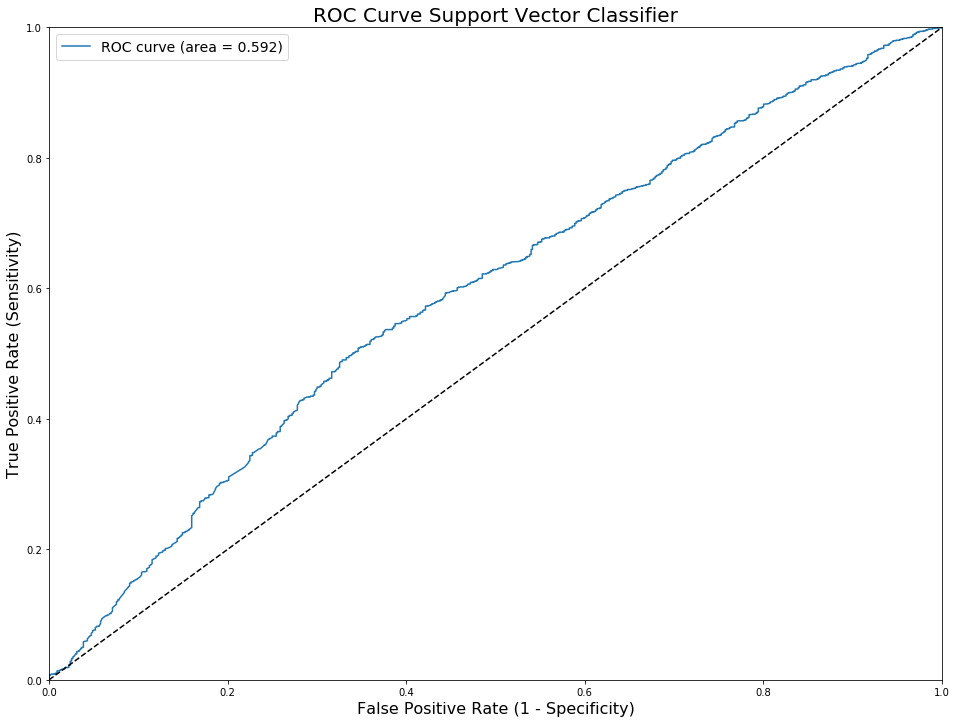

In [0]:
y_score=SV_clf.predict_proba(X_test)
y_score=y_score[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)
print('AUC: %.3f' % roc_auc)

# Plot ROC curve
plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve Support Vector Classifier', size=20)
plt.savefig('SVC_ROC')
plt.legend(fontsize=14);

AUC: 0.625


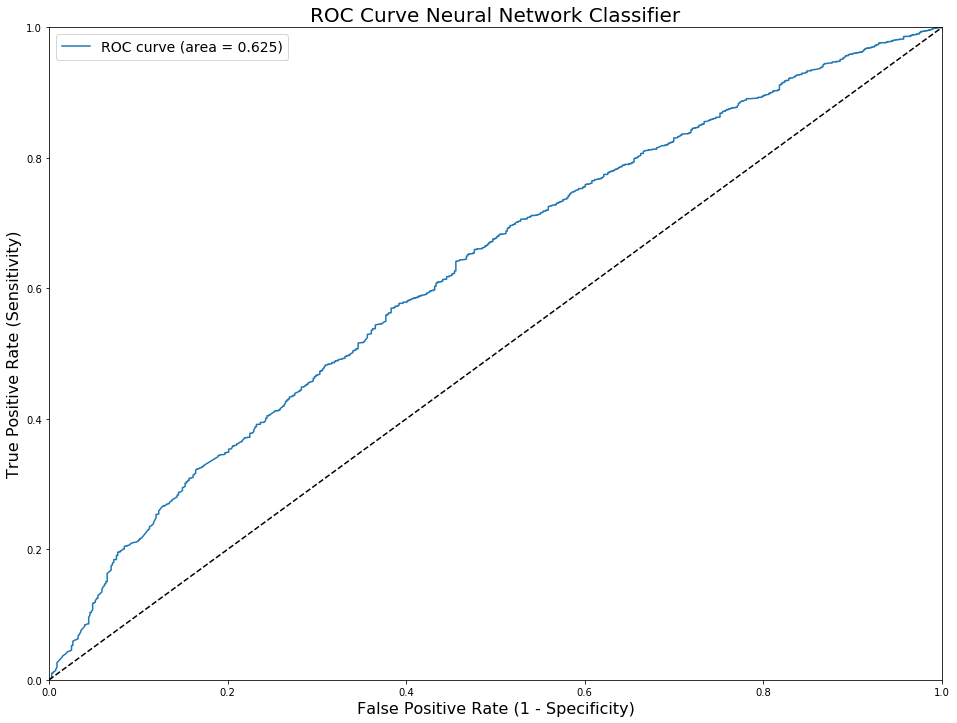

In [0]:
y_score=NN_clf.predict_proba(X_test)
y_score=y_score[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)
print('AUC: %.3f' % roc_auc)

# Plot ROC curve
plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve Neural Network Classifier', size=20)
plt.savefig('NN_ROC')
plt.legend(fontsize=14);

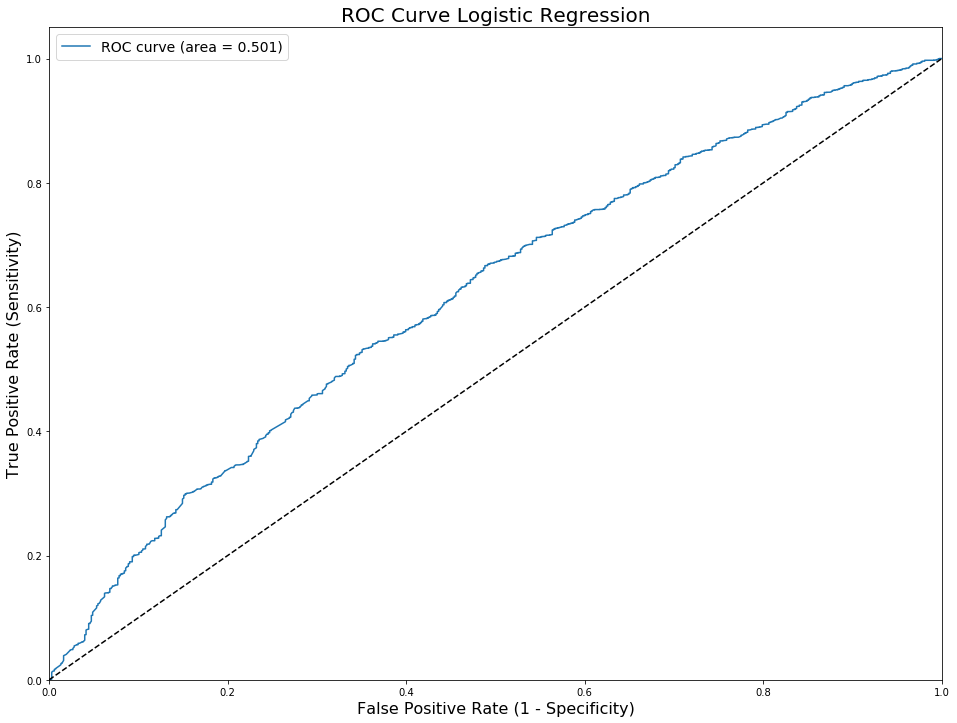

In [0]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

#plot ROC curve
plt.figure(figsize=(16,12))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', size = 16)
plt.ylabel('True Positive Rate (Sensitivity)', size = 16)
plt.title('ROC Curve Logistic Regression', size = 20)
plt.legend(loc="upper left", fontsize=14)
plt.savefig('Log_ROC')
plt.show()

In [0]:
SV_y_pred=SV_clf.predict(X_test)
GBC_y_pred=GBC_clf.predict(X_test)
RF_y_pred=RF_clf.predict(X_test)
NN_y_pred=NN_clf.predict(X_test)


print("Random Forest confusion matrix")
print(confusion_matrix(y_test.values, RF_y_pred))

print("Gradient Boosting Classifier confusion matrix")
print(confusion_matrix(y_test.values, GBC_y_pred))

print("Support Vector Classifier confusion matrix")
print(confusion_matrix(y_test.values, SV_y_pred))

print("Neural Network Classifier confusion matrix")
print(confusion_matrix(y_test.values, NN_y_pred))

print("Logistic regression confusion matrix")
print(confusion_matrix(y_test, y_pred))


Random Forest confusion matrix
[[  28  428]
 [   0 1901]]


In [0]:
y_test.values.mean()

0.8087694483734088

In [0]:
threshold = 0.15
predicted_proba_RF = RF_clf.predict_proba(X_test)
predicted_RF = (predicted_proba_RF [:,1] >= threshold).astype('int')

predicted_proba_SV = SV_clf.predict_proba(X_test)
predicted_SV = (predicted_proba_SV [:,1] >= threshold).astype('int')

predicted_proba_GBC = GBC_clf.predict_proba(X_test)
predicted_GBC = (predicted_proba_GBC [:,1] >= threshold).astype('int')

predicted_proba_NN = NN_clf.predict_proba(X_test)
predicted_NN = (predicted_proba_NN [:,1] >= threshold).astype('int')

print("Random Forest confusion matrix")
print(confusion_matrix(y_test.values, predicted_RF))

print("Gradient Boosting Classifier confusion matrix")
print(confusion_matrix(y_test.values, predicted_GBC))

print("Support Vector Classifier confusion matrix")
print(confusion_matrix(y_test.values, predicted_SV))

print("Neural Network Classifier confusion matrix")
print(confusion_matrix(y_test.values, predicted_NN))

Random Forest confusion matrix
[[   0  676]
 [   0 2859]]
Gradient Boosting Classifier confusion matrix
[[   0  676]
 [   0 2859]]
Support Vector Classifier confusion matrix
[[   9  667]
 [   7 2852]]
Neural Network Classifier confusion matrix
[[   0  676]
 [   0 2859]]


In [0]:
forest = RandomForestClassifier(n_estimators=3000, max_depth=3, random_state=42)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
idx = np.arange(0, X_train.shape[1]) #create an index array, with the number of features

features_to_keep=idx[importances > np.mean(importances)]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print (features_to_keep.shape)
# Print the feature ranking
print("Feature ranking:")

feature_list=[]
for f in range(4):
    print([X_train.iloc[:,features_to_keep].columns[f], importances[indices[f]]])
    feature_list.append(X_train.iloc[:,features_to_keep].columns[f])

In [0]:
feat_importances = pd.Series(forest.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [0]:
print(feature_list)

In [0]:
pca=PCA()
pca.fit(X_train)
X_train_pca=pca.transform(X_train)
X_test_pca = pca.transform(X_test)

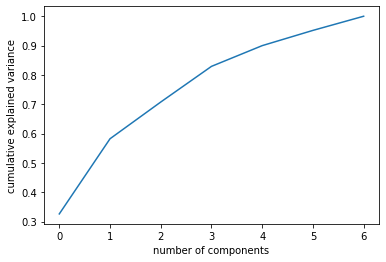

In [0]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');